<a href="https://colab.research.google.com/github/ZvoneST/pytorch-labs/blob/master/CNN_vs_Full_connected_NN_(MNIST)_part_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Step 1: Install Torch
- Execute the following cell which will install **torch** and **torchvision**

In [ ]:
#!pip install torchvision

### Step 2: Import libraries

In [ ]:
import torch
import torch.nn as nn
from torch import optim
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt
%matplotlib inline

### Step 3: Download the CIFAR10 dataset


In [ ]:
data_path = 'downloads/'
cifar10 = datasets.CIFAR10(data_path, train=True, download=True)
cifar10_val = datasets.CIFAR10(data_path, train=False, download=True)

Files already downloaded and verified
Files already downloaded and verified


### Step 4: Explore the dataset


In [ ]:
type(cifar10)

torchvision.datasets.cifar.CIFAR10

In [ ]:
len(cifar10), len(cifar10_val)

(50000, 10000)

In [ ]:
img, label = cifar10[1000]

### Step 5: Visualize the image


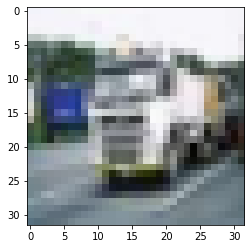

In [ ]:
plt.imshow(img)

### Step 6: Transform images


In [ ]:
tensor_cifar10 = datasets.CIFAR10(data_path, train = True, download = False, transform = transforms.ToTensor())

In [ ]:
imgs = torch.stack([img_t for img_t, _ in tensor_cifar10], dim = 3)

### Step 7: Normalize images


In [ ]:
imgs.view(3, -1).mean(dim = 1)   #Why is output a 3 number?

tensor([0.4914, 0.4822, 0.4465])

In [ ]:
imgs.view(3, -1).std(dim = 1) 

tensor([0.2470, 0.2435, 0.2616])

### Step 8: Normalize the data


In [ ]:
cifar10 = datasets.CIFAR10(data_path, train = True, download = False, transform = transforms.Compose([
                                                                                                             transforms.ToTensor(),
                                                                                                             transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))]))


In [ ]:
cifar10_val = datasets.CIFAR10(data_path, train = False, download = False, transform = transforms.Compose([
                                                                                                             transforms.ToTensor(),
                                                                                                             transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))]))


### Step 9: Limit the dataset


In [ ]:
label_map = {0: 0, 2: 1}
cifar2 = [(img, label_map[label]) for img, label in cifar10 if label in [0, 2]]
cifar2_val = [(img, label_map[label]) for img, label in cifar10_val if label in [0, 2]]


### Step 10: Create the model
**Ex2:** Which number need to written in place of x and y? 

In [ ]:
model = nn.Sequential(nn.Linear(32*32*3, 512), nn.Tanh(), nn.Linear(512, 2), nn.LogSoftmax(dim=1))

### Step 11: Train the model


In [ ]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=True)
learning_rate = 0.01
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
loss_fn = nn.NLLLoss()
n_epochs = 10
for epoch in range(n_epochs):
    for imgs, labels in train_loader:
        optimizer.zero_grad()

        batch_size = imgs.shape[0]
        outputs = model(imgs.view(batch_size, -1))
        loss = loss_fn(outputs, labels)

        loss.backward()
        optimizer.step()
    print("Epoch: %d, Loss: %f" % (epoch, float(loss)))

Epoch: 0, Loss: 0.438571
Epoch: 1, Loss: 0.512907
Epoch: 2, Loss: 0.655156
Epoch: 3, Loss: 0.501520
Epoch: 4, Loss: 0.272134
Epoch: 5, Loss: 0.624478
Epoch: 6, Loss: 0.331266
Epoch: 7, Loss: 0.353600
Epoch: 8, Loss: 0.135475
Epoch: 9, Loss: 0.447378


### Step 12: Test the model


In [ ]:
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64,
                                       shuffle=False)
correct = 0
total = 0
with torch.no_grad():
  for imgs, labels in val_loader:
      batch_size = imgs.shape[0]
      outputs = model(imgs.view(batch_size, -1))
      _, predicted = torch.max(outputs, dim=1)
      total += labels.shape[0]
      correct += int((predicted == labels).sum())
print("Accuracy: %f", correct / total)

Accuracy: %f 0.8445


### Step 13 (Optional): Improve the model


1.   Try with CNN
2.   ...



In [ ]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv3 = nn.Conv2d(20, 20, kernel_size=3)
        self.mp = nn.MaxPool2d(2)
        self.fc = nn.Linear(500, 2)

    def forward(self, x):
        in_size = x.size(0)
        x = F.relu(self.conv1(x))
        #print(x.shape)
        x = F.relu(self.mp(self.conv2(x)))
        x = F.relu(self.mp(self.conv3(x)))
        
        
        x = x.view(in_size, -1)  # flatten the tensor
        
        x = self.fc(x)
        return F.log_softmax(x)


model2 = Net()
#model = nn.Sequential(nn.Conv2d(3, 10, kernel_size=5),nn.MaxPool2d(2) ,nn.ReLU(), nn.Conv2d(10, 20, kernel_size=5),nn.MaxPool2d(2) ,nn.ReLU(), nn.Linear(500, 2), nn.Softmax(dim=1))

In [ ]:
from torch.autograd import Variable
import torch.nn.functional as F
optimizer = optim.SGD(model2.parameters(), lr=0.01, momentum=0.5)
test_loader = torch.utils.data.DataLoader(dataset=cifar2_val,
                                          batch_size=batch_size,
                                          shuffle=False)

def train(epoch):
    model2.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model2(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
       # if batch_idx % 10 == 0:
            #print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                #epoch, batch_idx * len(data), len(train_loader.dataset),
                #100. * batch_idx / len(train_loader), loss.item()))


def test():
    model2.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        data, target = Variable(data, volatile=True), Variable(target)
        output = model2(data)
        # sum up batch loss
        test_loss += F.nll_loss(output, target, size_average=False).data
        # get the index of the max log-probability
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))




### Ex3: Add more filtters


In [ ]:
class Net(nn.Module):



    def __init__(self):

        super(Net, self).__init__()

        self.conv1 = nn.Conv2d(3, 10, kernel_size=5)

        self.conv2 = nn.Conv2d(10, 20, kernel_size=3)

        self.conv3 = nn.Conv2d(20, 20, kernel_size=2)
        self.mp = nn.MaxPool2d(2)

        self.fc = nn.Linear(720, 2)



    def forward(self, x):

        in_size = x.size(0)

        x = F.relu(self.conv1(x))

        #print(x.shape)

        x = F.relu(self.mp(self.conv2(x)))

        x = F.relu(self.mp(self.conv3(x)))

        #x = F.relu(self.mp(self.conv4(x)))

        

        #print("2.", x.shape)

       # x = F.relu(self.mp(self.conv3(x)))

        x = x.view(in_size, -1)  # flatten the tensor

        #print("3.", x.shape)

        x = self.fc(x)

        return F.log_softmax(x)




model2 = Net()

In [ ]:
test()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 0.6952, Accuracy: 4311/10000 (43%)



# Ex4: Try ensamble method

In [ ]:

class MyEnsemble(nn.Module):
    def __init__(self, modelA, modelB):
        super(MyEnsemble, self).__init__()
        self.modelA = modelA
        self.modelB = modelB
        self.classifier = nn.Linear(3072, 2)
